In [52]:
import numpy as np
from PIL import Image
import cv2 as cv
import os
import matplotlib.pyplot as plt


In [53]:
def split_image(frame):
    """This takes a pair of stereo images and returns
    left and right frame w/o Alpha (fading) component
    of BGR"""
    frame = cv.cvtColor(frame, cv.COLOR_BGRA2BGR)
    height, width = frame.shape[:2]
    start_row, start_col = int(0), int(0)
    end_row, end_col = int(height), int(width * .5)
    left_frame = frame[start_row:end_row, start_col:end_col]
    start_row, start_col = int(0), int(width * .5)
    end_row, end_col = int(height), int(width)
    right_frame = frame[start_row: end_row, start_col: end_col]

    return left_frame, right_frame

def stereo2depth(L,R):

    # Parameters from all steps are defined here to make it easier to adjust values.
    resolution     = 1.0    # (0, 1.0]
    numDisparities = 16     # has to be dividable by 16
    blockSize      = 1      # (0, 25]
    windowSize     = 1      # Usually set equals to the block size
    filterCap      = 63     # [0, 100]
    lmbda          = 80000  # [80000, 100000]
    sigma          = 1.2
    brightness     = 0      # [-1.0, 1.0]
    contrast       = 1      # [0.0, 3.0]

    imgL = L
    imgR = R
    height, width, _ = L.shape

    # Step 3 - Downsampling the images to the resolution level to speed up the matching at the cost of quality degradation.
    resL = cv.resize(imgL, None, fx = resolution, fy = resolution, interpolation = cv.INTER_AREA)
    resR = cv.resize(imgR, None, fx = resolution, fy = resolution, interpolation = cv.INTER_AREA)

    # Step 4 - Setup two stereo matchers to compute disparity maps both for left and right views.
    left_matcher = cv.StereoSGBM_create(
        minDisparity = 1,
        numDisparities = numDisparities,
        blockSize = blockSize,
        P1 = 8 * 3 * windowSize ** 2,
        P2 = 32 * 3 * windowSize ** 2,
        disp12MaxDiff = 1,
        uniquenessRatio = 15,
        speckleWindowSize = 0,
        speckleRange = 2,
        preFilterCap = filterCap,
        mode = cv.STEREO_SGBM_MODE_HH # Run on HH mode which is more accurate than the default mode but much slower so it might not suitable for real-time scenario.
    )
    right_matcher = cv.ximgproc.createRightMatcher(left_matcher)

    # Step 5 - Setup a disparity filter to deal with stereo-matching errors.
    #          It will detect inaccurate disparity values and invalidate them, therefore making the disparity map semi-sparse.
    wls_filter = cv.ximgproc.createDisparityWLSFilter(matcher_left = left_matcher)
    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)

    # Step 6 - Perform stereo matching to compute disparity maps for both left and right views.
    displ = left_matcher.compute(resL, resR)
    dispr = right_matcher.compute(resR, resL)

    # Step 7 - Perform post-filtering
    imgLb = cv.copyMakeBorder(imgL, top = 0, bottom = 0, left = np.uint16(numDisparities / resolution), right = 0, borderType= cv.BORDER_CONSTANT, value = [155,155,155])
    filteredImg = wls_filter.filter(displ, imgLb, None, dispr)

    # Step 8 - Adjust image resolution, brightness, contrast, and perform disparity truncation hack
    filteredImg = filteredImg * resolution
    filteredImg = filteredImg + (brightness / 100.0)
    filteredImg = (filteredImg - 128) * contrast + 128
    filteredImg = np.clip(filteredImg, 0, 255)
    filteredImg = np.uint8(filteredImg)
    filteredImg = cv.resize(filteredImg, (width, int(height)), interpolation = cv.INTER_CUBIC) # Disparity truncation hack
    filteredImg = filteredImg[0:height, np.uint16(numDisparities / resolution):width]
    filteredImg = cv.resize(filteredImg, (width,int(height)), interpolation = cv.INTER_CUBIC)  # Disparity truncation hack

    return filteredImg

In [54]:
img1,img2 = split_image(cv.imread("img3.png"))

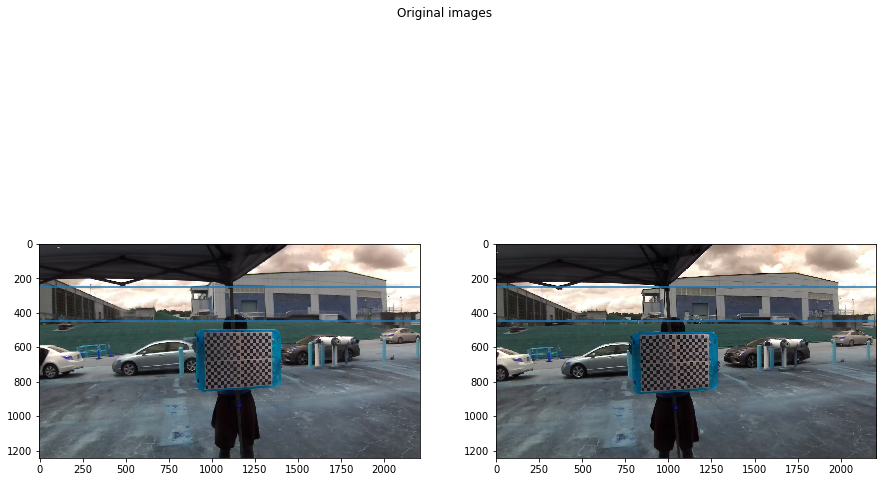

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1, cmap="gray")
axes[1].imshow(img2, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Original images")
plt.show()

In [56]:
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

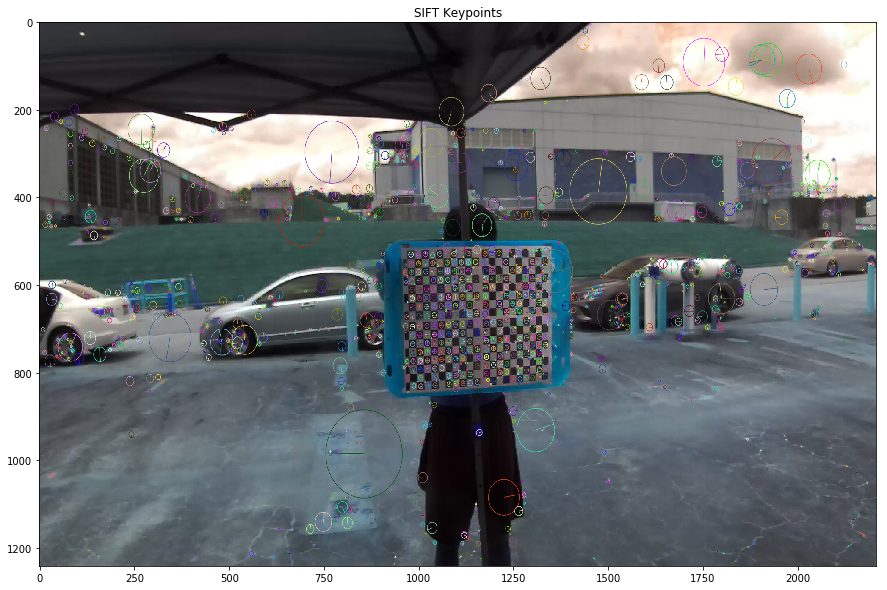

In [57]:
# Visualize keypoints
imgSift = cv.drawKeypoints(
    img1, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# cv.imshow("SIFT Keypoints", imgSift)
plt.figure(figsize=(15, 10))
plt.imshow(imgSift, aspect='auto')
plt.title('SIFT Keypoints')
plt.show()

In [58]:
# Match keypoints in both images
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=250)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Keep good matches: calculate distinctive image features
# Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94
# https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

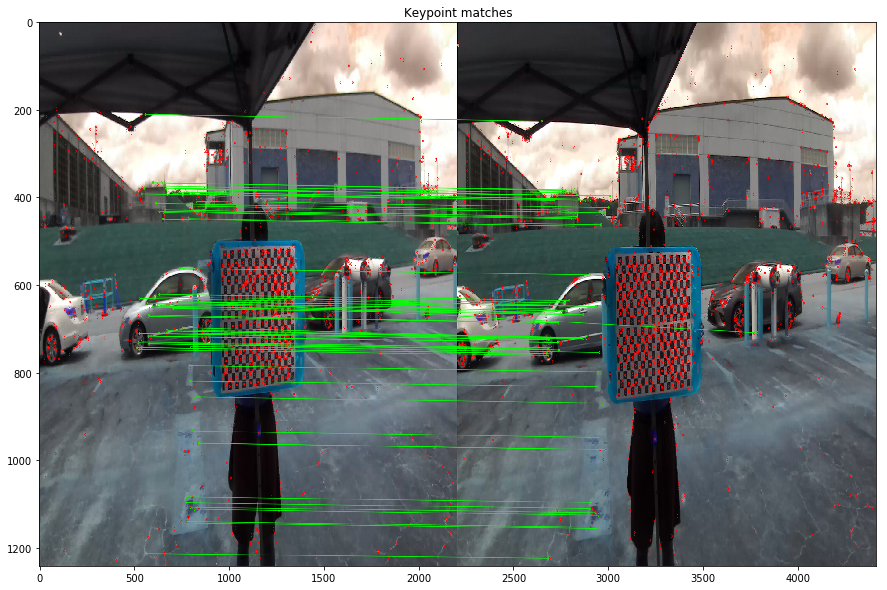

In [59]:
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask[300:500],
                   flags=cv.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv.drawMatchesKnn(
    img1, kp1, img2, kp2, matches[300:500], None, **draw_params)

plt.figure(figsize=(15, 10))
plt.imshow(keypoint_matches, aspect='auto')
plt.title('Keypoint matches')
plt.show()

In [60]:
# STEREO RECTIFICATION

# Calculate the fundamental matrix for the cameras
# https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

In [43]:
# img1,img2 = split_image(cv.imread("img2.png"))

In [61]:
# Stereo rectification (uncalibrated variant)
# Adapted from: https://stackoverflow.com/a/62607343
h1, w1, channel = img1.shape
h2, w2, channel = img2.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

In [62]:
# Undistort (rectify) the images and save them
# Adapted from: https://stackoverflow.com/a/62607343
img1_rectified = cv.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv.warpPerspective(img2, H2, (w2, h2))
cv.imwrite(filename + "rectified_1.png", img1_rectified)
cv.imwrite(filename + "rectified_2.png", img2_rectified)

True

In [64]:
depth = stereo2depth(img2_rectified,img1_rectified)
cv.imwrite("depth.png", depth)

True